# Quantum-enhanced Support Vector Machine (QSVM)

Classification algorithms and methods for machine learning are essential for pattern recognition and data mining applications. Well known techniques such as support vector machines and neural networks have blossomed over the last two decades as a result of the spectacular advances in classical hardware computational capabilities and speed. This progress in computer power made it possible to apply techniques, that were theoretically developed towards the middle of the 20th century, on classification problems that were becoming increasingly challenging.

A key concept in classification methods is that of a kernel. Data cannot typically be separated by a hyperplane in its original space. A common technique used to find such a hyperplane consists of applying a non-linear transformation function to the data. This function is called a feature map, as it transforms the raw features, or measurable properties, of the phenomenon or subject under study. Classifying in this new feature space -and, as a matter of fact, also in any other space, including the raw original one- is nothing more than seeing how close data points are to each other. This is the same as computing the inner product for each pair of data points in the set. So, in fact we do not need to compute the non-linear feature map for each datum, but only the inner product of each pair of data points in the new feature space. This collection of inner products is called the kernel and it is perfectly possible to have feature maps that are hard to compute but whose kernels are not.

In this notebook we provide an example of a classification problem that requires a feature map for which computing the kernel is not efficient classically -this means that the required computational resources are expected to scale exponentially with the size of the problem. We show how this can be solved in a quantum processor by a direct estimation of the kernel in the feature space. The method we used falls in the category of what is called supervised learning, consisting of a training phase (where the kernel is calculated and the support vectors obtained) and a test or classification phase (where new unlabeled data is classified according to the solution found in the training phase).

References and additional details:

[1] Vojtech Havlicek, Antonio D. C´orcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, "Supervised learning with quantum enhanced feature spaces," [arXiv: 1804.11326](https://arxiv.org/pdf/1804.11326.pdf)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVM
from qiskit_machine_learning.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
algorithm_globals.random_seed = seed

# The ad hoc data set

As a first example we will use the ad hoc dataset as described in the above referenced paper. From the dataset we take samples for use as training, testing and the final prediction (datapoints).

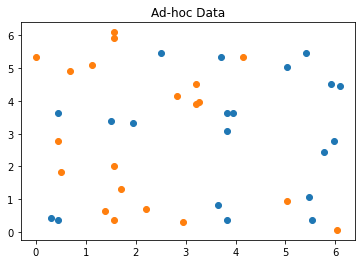

{'A': 0, 'B': 1}


In [2]:
from qiskit_machine_learning.datasets import ad_hoc_data, sample_ad_hoc_data

feature_dim = 2
sample_total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
    gap=0.3, 
    plot_data=True
)
extra_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_to_label)

With the dataset ready we can setup the [QSVM](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.QSVM.html) algorithm to do a classification. Here we use the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) data encoding circuit from the Qiskit circuit library.

Here the BasicAer `qasm_simulator` is used with 1024 shots.

For the testing, the result includes the details and the success ratio. For the prediction, the result includes the predicted labels. 

In [3]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

Testing success ratio: 1.0

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  success rate: 100.0%


The following shows the kernel matrix that was built from the training sample of the dataset.

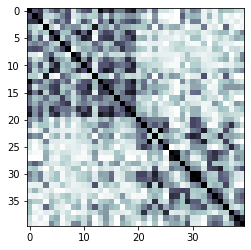

In [4]:
kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r');

Qiskit also has a classical SVM implementation that takes the same input data for classification. Let's run this and do a comparison. Now the ad hoc data set was created to show that there can be datasets where quantum could give an advantage.

Testing success ratio: 0.65

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['B', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'A']
  success rate: 55.0%


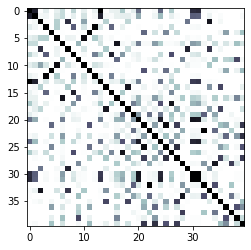

In [5]:
from qiskit_machine_learning.algorithms import SklearnSVM

result = SklearnSVM(training_input, test_input, datapoints[0]).run()

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r');

## The breast cancer dataset

Now we run our algorithm with a real-world dataset: the breast cancer dataset, we use the first two principal components as features.

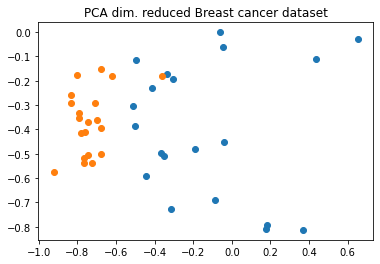

In [6]:
from qiskit_machine_learning.datasets import breast_cancer

feature_dim = 2
sample_total, training_input, test_input, class_labels = breast_cancer(
    training_size=20,
    test_size=10,
    n=feature_dim,
    plot_data=True
)

In [7]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 0.9


The kernel matrix that was built from the training sample of the dataset.

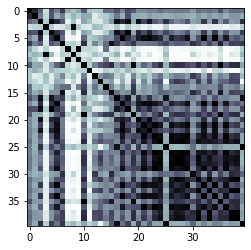

In [8]:
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')

Again we are able to compare the result to a classical approach.

Testing success ratio: 0.85


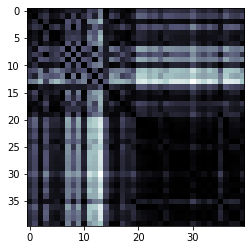

In [9]:
result = SklearnSVM(training_input, test_input).run()

print(f'Testing success ratio: {result["testing_accuracy"]}')

kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r');

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright